In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from geotext import GeoText
from gensim.models import CoherenceModel
import gensim
import os
import re
pwd = os.getcwd()

## Load the Dataset

In [82]:
df = pd.read_csv(os.path.basename(pwd+'/Eluvio_DS_Challenge.csv'))

In [83]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [84]:
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

In [ ]:
df.drop(['category','down_votes'], axis=1, inplace=True)

- All the columns has No missing values
- **Category is worldnews and down_votes is zero for all the columns, I have removed these 2 column as these will have any significance**

# Feature Analysis

In [7]:
df["Month"] = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d').strftime('%B'), df['date_created']))
df["Year"]  = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d').strftime('%Y'), df['date_created']))
df["day"]   = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d').strftime("%A"), df['date_created']))

In [8]:
df.drop(['time_created','date_created'], axis=1, inplace=True)

In [9]:
df.head()

,up_votes,title,over_18,author,Month,Year,day
0,3,Scores killed in Pakistan clashes,False,polar,January,2008,Friday
1,2,Japan resumes refuelling mission,False,polar,January,2008,Friday
2,3,US presses Egypt on Gaza border,False,polar,January,2008,Friday
3,1,Jump-start economy: Give health care to all,False,fadi420,January,2008,Friday
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,January,2008,Friday


<AxesSubplot:xlabel='Year', ylabel='avg_upvotes'>

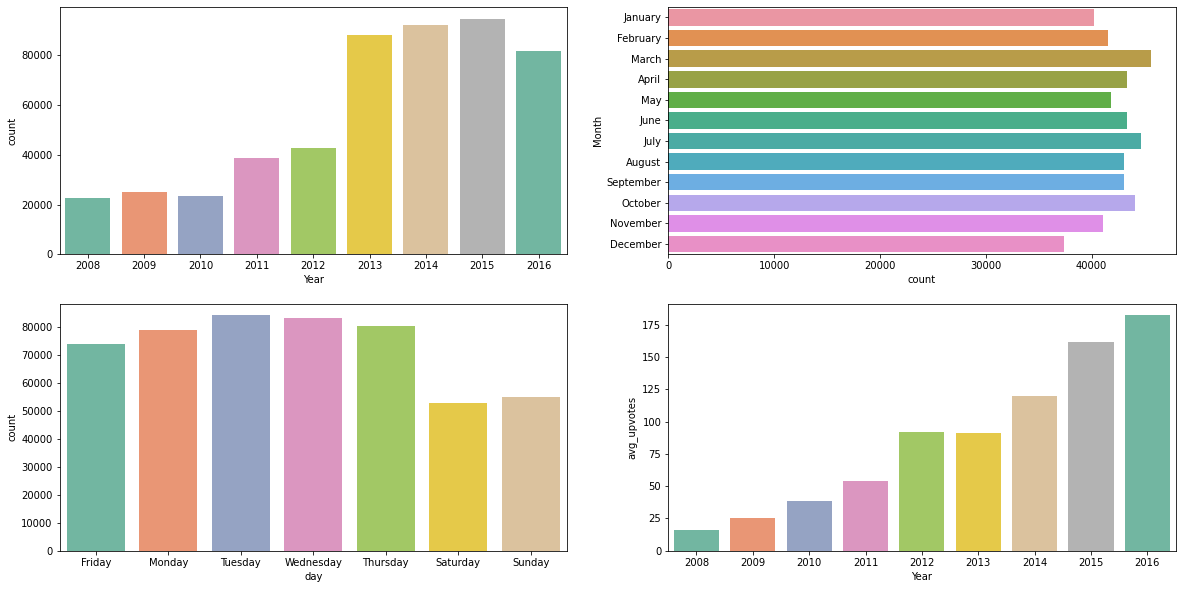

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.countplot(x='Year',data=df, ax=ax[0,0],palette="Set2")
sns.countplot(y='Month',data=df, ax=ax[0,1])
sns.countplot(x='day',data=df, ax=ax[1,0],palette="Set2")

avg = df.groupby('Year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='Year',y='avg_upvotes',data=avg, ax=ax[1,1],palette="Set2")

In [11]:
df.sort_values(by=['up_votes'], ascending=False)[:5]

,up_votes,title,over_18,author,Month,Year,day
377200,21253,A biotech startup has managed to 3-D print fak...,False,KRISHNA53,June,2015,Saturday
391415,13435,Twitter has forced 30 websites that archive po...,False,joeyoungblood,August,2015,Monday
450818,13244,2.6 terabyte leak of Panamanian shell company ...,False,mister_geaux,April,2016,Sunday
391318,12333,The police officer who leaked the footage of t...,False,navysealassulter,August,2015,Sunday
390252,11288,Paris shooting survivor suing French media for...,False,seapiglet,August,2015,Tuesday


## Exploratory Analysis

Wordcloud package to get a visual representation of most common words

In [12]:
from wordcloud import WordCloud
from gensim.models import KeyedVectors
# wv_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True)

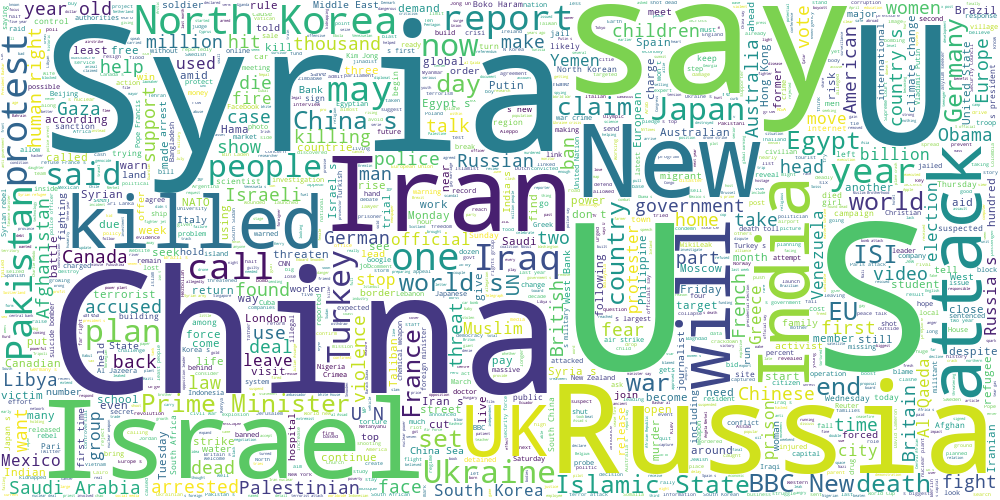

<Figure size 1080x576 with 0 Axes>

In [13]:
# Join the different processed titles together.
long_string = ','.join(list(df['title'].values))# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5,
                      width = 1000, height = 500,contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
plt.figure(figsize=(15,8))
wordcloud.to_image()

From the WordCloud I have noticed that Title consist of so countries that's why I decided to add feature **Country**

In [14]:
def get_country(text):
    count = GeoText(text).countries
    w = ''
    if not count :
        return np.nan
    else:
        for country in count:
            w = w+' '+country
        return w    

In [15]:
df['country'] = df['title'].map(lambda com : get_country(com))

<AxesSubplot:xlabel='count', ylabel='country'>

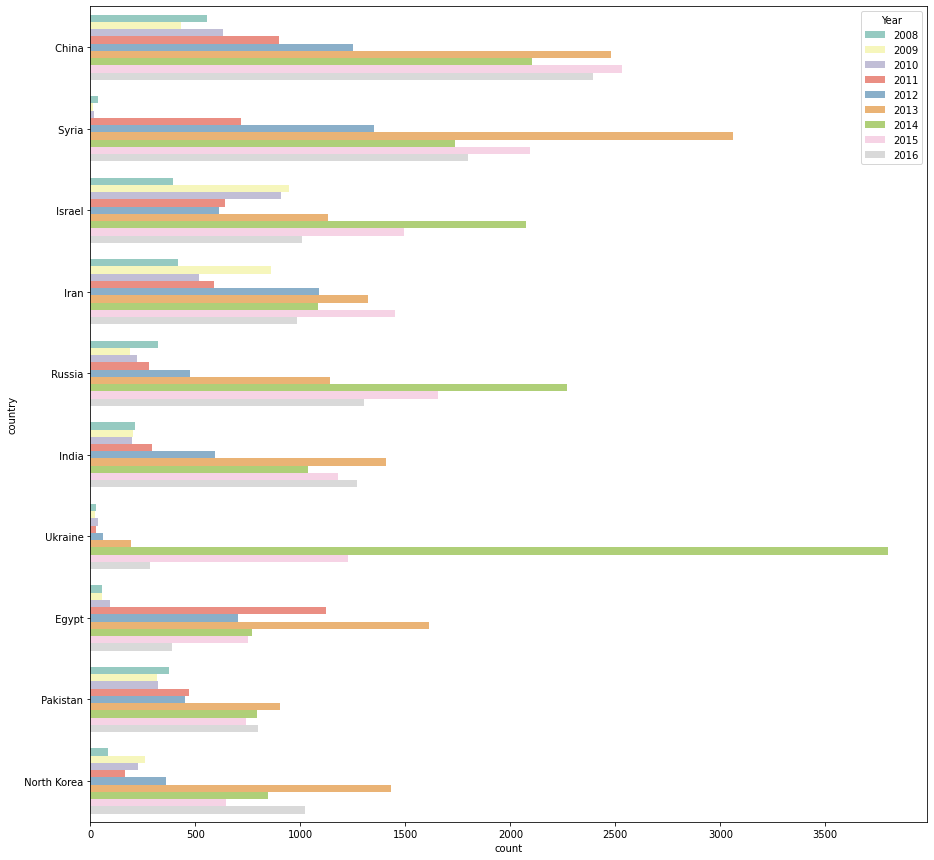

In [16]:
fig = plt.figure(figsize=(15,15))
sns.countplot(y='country',
              order = df['country'].value_counts().iloc[:10].index,data=df,
              hue=df['Year'],palette="Set3")

In [17]:
#Top 15 Author with maximum number of Titles

<AxesSubplot:xlabel='count', ylabel='author'>

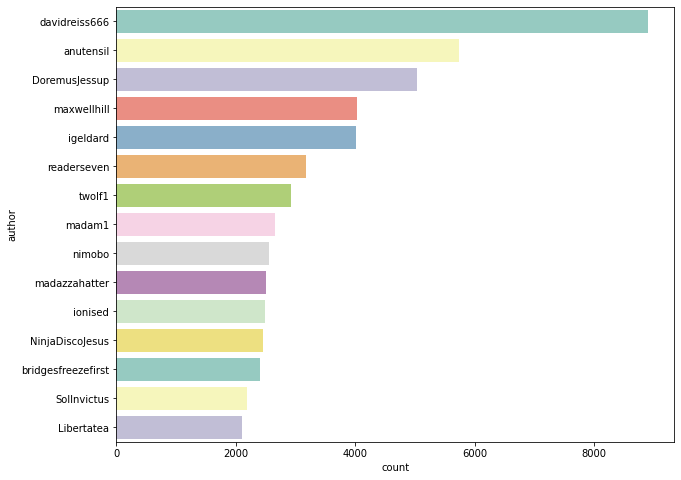

In [18]:
plt.figure(figsize=(10,8))
sns.countplot(y='author',
              order = df['author'].value_counts().iloc[:15].index,data=df,
              palette="Set3")

# Sentiment analysis of the title

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [23]:
sid_obj = SentimentIntensityAnalyzer() 

rating=[]

for i in range(len(df["title"])):
    sentiment_score = sid_obj.polarity_scores(df["title"][i])
    sentiment_score = sentiment_score["compound"]
    rating.append(sentiment_score)

is_sentiment = []
for i in range(len(rating)):
    if rating[i]>0.05:
        is_sentiment.append("Positive")
    elif rating[i]<-0.05:
        is_sentiment.append("Negative")
    else:
        is_sentiment.append("Neutral")

df = df.assign(is_sentiment = is_sentiment)

In [24]:
df["is_sentiment"].value_counts()

Negative    265991
Neutral     144120
Positive     99125
Name: is_sentiment, dtype: int64

**It is evident that title column has more number titles with Negative sentiment as compared to others**

<AxesSubplot:xlabel='is_sentiment', ylabel='count'>

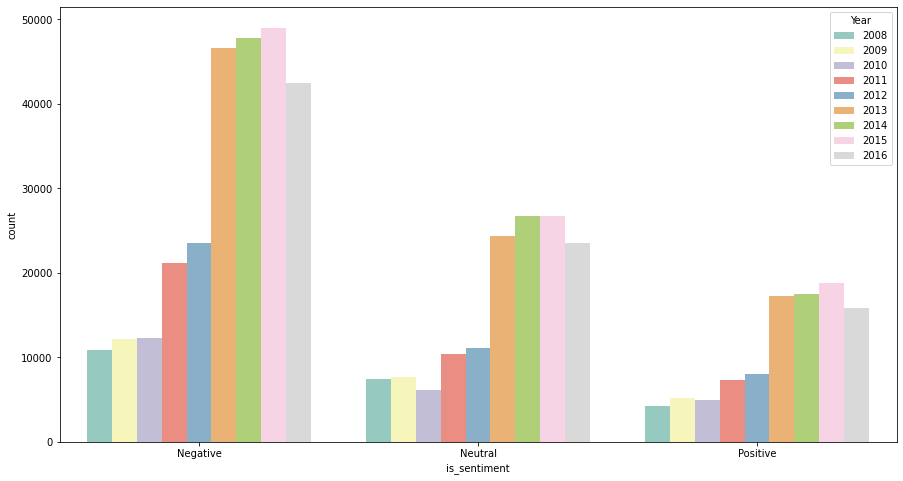

In [25]:
fig = plt.figure(figsize=(15,8))
sns.countplot(x='is_sentiment',data=df,
              hue=df['Year'],palette="Set3")

# Topic Modeling: LDA 

In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  
import gensim.corpora as corpora
from gensim import corpora, models

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer() 
stopword = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = text.strip(' ')
    return text

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopword] for doc in texts]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

class Doc2Vec:
    def __init__(self, wv_model, corpus):
        self.word2vec_model = wv_model
        self.corpus = corpus
        
    def filter_docs(self, texts, condition_on_doc):
        number_of_docs = len(self.corpus)
        texts = [text for (text, doc) in zip(texts, self.corpus)
                 if condition_on_doc(doc)]
        corpus = [doc for doc in self.corpus if condition_on_doc(doc)]
        print("{} docs removed".format(number_of_docs - len(corpus)))
        return (corpus, texts)
    
    def has_vector_representation(self, doc):
        return not all(word not in self.word2vec_model.vocab for word in doc)
    
    def document_vector(self, doc):
        # remove out-of-vocabulary words
        doc = [word for word in doc if word in self.word2vec_model.vocab]
        return np.mean(self.word2vec_model[doc], axis=0)

In [28]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

Clean and preprocess the Title

In [29]:
df['title'] = df['title'].map(lambda com : clean_text(com))

In [30]:
text = df['title']
titles_list = [title for title in text]

In [31]:
corpus = df['title'].map(clean_text)

temp = Doc2Vec(wv, corpus)
corpus, titles_left = temp.filter_docs(titles_list, lambda doc: temp.has_vector_representation(doc))

# Initialize an array for the size of the corpus
x = []
for doc in corpus: 
    x.append(temp.document_vector(doc))
docvec = np.array(x)

6 docs removed


In [32]:
print(np.shape(docvec))

(509230, 300)


In [33]:
# Initialize t-SNE
from sklearn.manifold import TSNE
from adjustText import adjust_text
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(docvec[:400])

- TSNE is a tool to visualize high-dimensional data.
- It converts similarities between data points to joint probabilities

65

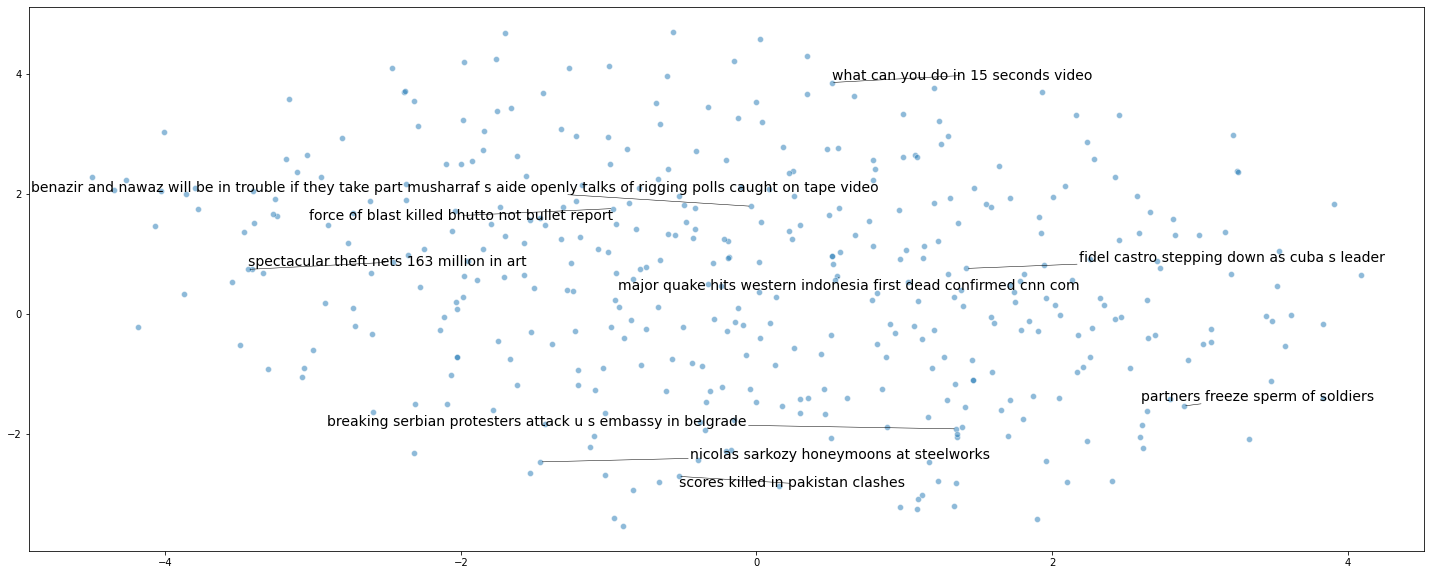

In [34]:
texts = []
fig, ax = plt.subplots(figsize = (25, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)
titles_to_plot = list(np.arange(0, 400, 40))
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

In [35]:
data = df.title.values.tolist()

In [36]:
data_words = list(sent_to_words(data))

In [37]:
print(data_words[2])

['us', 'presses', 'egypt', 'on', 'gaza', 'border']


In [38]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [39]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [40]:
data_words_bigrams = make_bigrams(data_words_nostops)

In [41]:
data_lemmatized = lemmatization(data_words_bigrams)

In [42]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [43]:
print('Number of unique words in initital documents:', len(dictionary))

Number of unique words in initital documents: 80821


In [44]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 clash
1 killed
2 pakistan
3 score
4 japan
5 mission
6 refuelling
7 resume
8 border
9 egypt
10 gaza


# Gensim doc2bow

In [46]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [47]:
bow_doc_489 = bow_corpus[489]
for i in range(len(bow_doc_489)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_489[i][0], 
                                               dictionary[bow_doc_489[i][0]], 
bow_doc_489[i][1]))

Word 118 ("uk") appears 1 time.
Word 153 ("flight") appears 1 time.
Word 921 ("mid") appears 1 time.
Word 1351 ("pilot") appears 1 time.
Word 1798 ("dy") appears 1 time.
Word 1799 ("passenger_jet") appears 1 time.


# Topic modeling using :LDA

In [48]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10, 
                                       id2word=dictionary,
                                       passes=2, workers=2)


In [49]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"isi" + 0.026*"president" + 0.017*"say" + 0.015*"leader" + 0.014*"turkey" + 0.014*"minister" + 0.013*"islamic_state" + 0.012*"eu" + 0.010*"pm" + 0.009*"russia"
Topic: 1 
Words: 0.032*"police" + 0.027*"protest" + 0.018*"yemen" + 0.014*"migrant" + 0.012*"anti" + 0.011*"egypt" + 0.010*"paris" + 0.009*"protester" + 0.008*"libya" + 0.008*"activist"
Topic: 2 
Words: 0.011*"china" + 0.010*"u" + 0.010*"government" + 0.009*"court" + 0.009*"law" + 0.009*"say" + 0.008*"uk" + 0.007*"report" + 0.007*"new" + 0.007*"journalist"
Topic: 3 
Words: 0.040*"attack" + 0.026*"killed" + 0.017*"kill" + 0.015*"syrian" + 0.015*"force" + 0.013*"pakistan" + 0.011*"dead" + 0.011*"say" + 0.010*"strike" + 0.010*"least"
Topic: 4 
Words: 0.026*"year" + 0.017*"million" + 0.016*"world" + 0.012*"oil" + 0.012*"first" + 0.012*"billion" + 0.011*"bank" + 0.011*"mosul" + 0.010*"china" + 0.010*"global"
Topic: 5 
Words: 0.046*"syria" + 0.028*"russia" + 0.027*"u" + 0.025*"iran" + 0.023*"israel" + 0.023*"dea

# Running LDA using TF-IDF

In [50]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [51]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                             id2word=dictionary,
                                             passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.008*"president" + 0.006*"erdogan" + 0.005*"turkey" + 0.005*"say" + 0.005*"court" + 0.004*"assad" + 0.004*"duterte" + 0.004*"leader" + 0.003*"former" + 0.003*"israel"
Topic: 1 Word: 0.013*"attack" + 0.011*"killed" + 0.009*"kill" + 0.007*"police" + 0.006*"syria" + 0.006*"iraq" + 0.006*"militant" + 0.006*"bomb" + 0.005*"least" + 0.005*"dead"
Topic: 2 Word: 0.006*"crimea" + 0.004*"libyan" + 0.003*"cyber" + 0.003*"refugee_camp" + 0.003*"new" + 0.003*"detains" + 0.003*"say" + 0.003*"unity" + 0.003*"fleeing" + 0.003*"specie"
Topic: 3 Word: 0.004*"law" + 0.004*"china" + 0.004*"uk" + 0.003*"new" + 0.003*"google" + 0.003*"facebook" + 0.003*"internet" + 0.003*"court" + 0.003*"government" + 0.003*"ban"
Topic: 4 Word: 0.007*"china" + 0.007*"ebola" + 0.006*"sea" + 0.005*"migrant" + 0.005*"south" + 0.005*"mh" + 0.005*"missing" + 0.004*"death_toll" + 0.004*"earthquake" + 0.004*"plane"
Topic: 5 Word: 0.010*"russia" + 0.008*"china" + 0.008*"u" + 0.007*"deal" + 0.007*"iran" + 0.007*"eu" 

In [52]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.450257442688097

Coherence Score:  0.3342352183103908


# Models

- Predicting the number of up_votes based on the content of Title.
- I calculated threshold of Up_votes to build a classification model

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve

from sklearn.pipeline import Pipeline

In [54]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [55]:
threshold = np.quantile(df['up_votes'], 0.8)
y = [1 if i > threshold else 0 for i in df['up_votes']]
df['up_voteCat'] = np.where(df['up_votes'] > threshold, 1,0)

In [56]:
#checking the split
print(df["up_voteCat"].value_counts()/len(df))

0    0.804611
1    0.195389
Name: up_voteCat, dtype: float64


## Resampling to get more balanced data


    Down-sampling (Under sampling) the majority class
    We can see that the split is extremely imbalanced, this split is also evident in the Bar graph shown above


In [57]:
ros = RandomOverSampler()

# Class count
count_class_0, count_class_1 = df.up_voteCat.value_counts()

# Divide by class
df_class_0 = df[df['up_voteCat'] == 0]
df_class_1 = df[df['up_voteCat'] == 1]

Random under-sampling:
0    99499
1    99499
Name: up_voteCat, dtype: int64


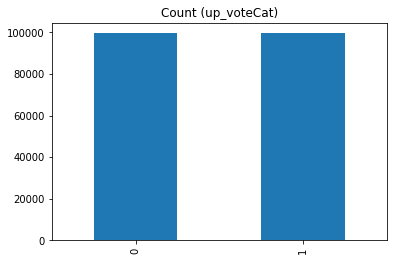

In [58]:
df_class_0_under = df_class_0.sample(count_class_1)
X = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(X.up_voteCat.value_counts())

X.up_voteCat.value_counts().plot(kind='bar', title='Count (up_voteCat)');

In [59]:
train, test = train_test_split(X, random_state=42, test_size=0.30, stratify = X['up_voteCat'], shuffle=True)
X_train = train.title
X_test = test.title
print(X_train.shape)
print(X_test.shape)

(139298,)
(59700,)


In [60]:
#checking the split
print(train.up_voteCat.value_counts()/len(train))
print(test.up_voteCat.value_counts()/len(test))

0    0.5
1    0.5
Name: up_voteCat, dtype: float64
0    0.5
1    0.5
Name: up_voteCat, dtype: float64


In [61]:
X_train.head()

179244    indian shop owner passionate for education run...
312287    syrian free army and nusra al qaeda team toget...
449054    giulio regeni egypt s claim italian killed by ...
277658    twitter agrees to block blasphemous tweets in ...
495904    thailand reports first two cases of zika birth...
Name: title, dtype: object

In [ ]:
def model_eval(pipeline,n):
    
    pipeline.fit(X_train, train['up_voteCat'])
    y_predict = pipeline.predict(X_test)
    
    
#     print('Accuracy :{}'.format(accuracy_score(test['up_voteCat'],y_predict)))
#     print('Precision: {}'.format(precision_score(test['up_voteCat'],y_predict)))
#     print('Recall: {}'.format(recall_score(test['up_voteCat'],y_predict)))
#     print('Fmeasure: {}'.format(f1_score(test['up_voteCat'],y_predict)))
    print(classification_report(test['up_voteCat'], y_predict))
    return [test['up_voteCat'],y_predict]
    

# Naive Bayes

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
nb_cm = model_eval(NB_pipeline,1)

              precision    recall  f1-score   support

           0       0.62      0.57      0.60     29850
           1       0.60      0.65      0.63     29850

    accuracy                           0.61     59700
   macro avg       0.61      0.61      0.61     59700
weighted avg       0.61      0.61      0.61     59700



# Logistic Regression
- Logistic regression utilizes a sigmoid function and works best on binary classification problems

In [72]:
from sklearn.linear_model import LogisticRegression
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

lr_cm = model_eval(LogReg_pipeline,2)

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     29850
           1       0.63      0.63      0.63     29850

    accuracy                           0.63     59700
   macro avg       0.63      0.63      0.63     59700
weighted avg       0.63      0.63      0.63     59700



**Conclusion**:
- Logistic Regression performed slightly better than Naive bayes
- I had to Under sample large portion of the data,despite that I got an accuracy of 63%.

**Thing to do in future:**
- Use different model like ANN, Random forest to analyze that text and classify.
- Perform hyperparameter tunning.
- Perform similar analysis with regression model and predict up_votes.
